In [7]:
import numpy as np

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score


In [8]:
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [10]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

log_preds = log_model.predict(X_test)


In [12]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

dt_preds = dt_model.predict(X_test)


In [13]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)


In [14]:
def evaluate_model(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_pred)
    }


In [27]:
results = pd.DataFrame([
    evaluate_model(y_test, log_preds),
    evaluate_model(y_test, dt_preds),
    evaluate_model(y_test, rf_preds)
], index=["Logistic Regression", "Decision Tree", "Random Forest"])

results


,Accuracy,Precision,Recall,ROC-AUC
Logistic Regression,0.973684,0.972222,0.985915,0.969702
Decision Tree,0.947368,0.957746,0.957746,0.943990
Random Forest,0.964912,0.958904,0.985915,0.958074


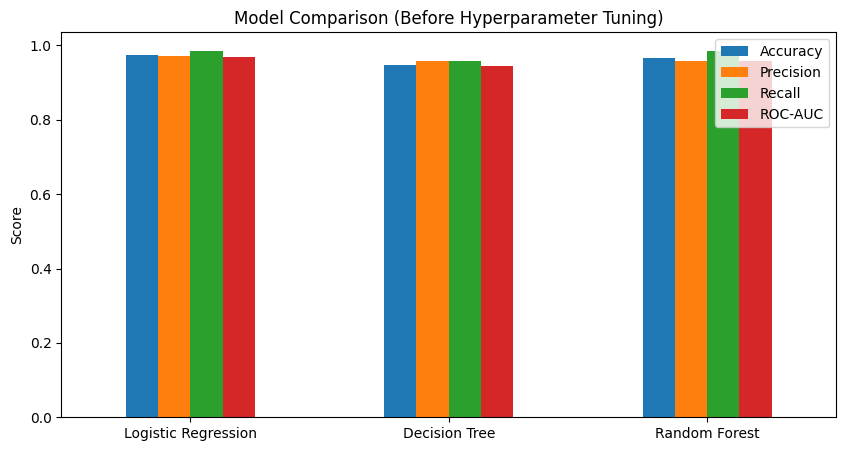

In [16]:
results.plot(kind="bar", figsize=(10,5))
plt.title("Model Comparison (Before Hyperparameter Tuning)")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()


In [17]:
dt_params = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    cv=5,
    scoring='roc_auc'
)

dt_grid.fit(X_train, y_train)

dt_best = dt_grid.best_estimator_
dt_best


,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [18]:
dt_tuned_preds = dt_best.predict(X_test)

dt_tuned_results = evaluate_model(y_test, dt_tuned_preds)
dt_tuned_results


{'Accuracy': 0.956140350877193,
 'Precision': 0.9583333333333334,
 'Recall': 0.971830985915493,
 'ROC-AUC': 0.9510317720275139}

In [19]:
comparison = pd.DataFrame({
    "Before Tuning": results.loc["Decision Tree"],
    "After Tuning": dt_tuned_results
})

comparison


,Before Tuning,After Tuning
Accuracy,0.947368,0.956140
Precision,0.957746,0.958333
Recall,0.957746,0.971831
ROC-AUC,0.943990,0.951032


In [20]:
final_results = pd.DataFrame([
    evaluate_model(y_test, log_preds),
    dt_tuned_results,
    evaluate_model(y_test, rf_preds)
], index=["Logistic Regression", "Decision Tree (Tuned)", "Random Forest"])

final_results


,Accuracy,Precision,Recall,ROC-AUC
Logistic Regression,0.973684,0.972222,0.985915,0.969702
Decision Tree (Tuned),0.956140,0.958333,0.971831,0.951032
Random Forest,0.964912,0.958904,0.985915,0.958074


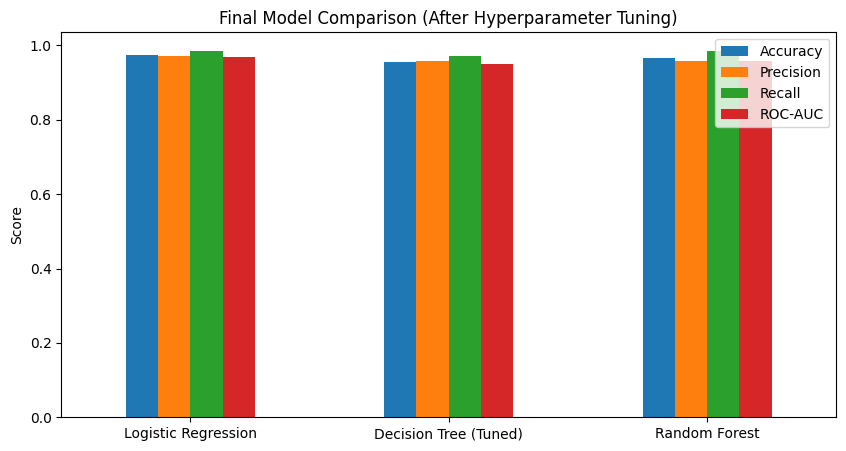

In [21]:
final_results.plot(kind="bar", figsize=(10,5))
plt.title("Final Model Comparison (After Hyperparameter Tuning)")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()
